# Tensorflow - Cat State Detect - Project

![Ảnh minh họa mèo](https://i.ytimg.com/vi/HIdLXBn-Py0/maxresdefault.jpg)

# Xây dựng mô hình

## 1. Import thư viện cần thiết

In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import IPython.display as ipd
import librosa
import librosa.display
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
import tensorflow_io as tfio

import warnings
warnings.filterwarnings("ignore")

Kiểm tra xem tensorflow đang sử dụng GPU (khuyến khích) hay CPU

In [2]:
print(tf.config.list_physical_devices('GPU'))
tf.test.is_gpu_available()

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

## 2. Phân tích khai phá dữ liệu (EDA)

- Kiểm tra sơ đồ thư mục

In [3]:
DATA_PATH = 'dataset/dataset/'

In [4]:
# Trạng thái mèo 'F' : 'Waiting For Food', 'I' : 'Isolated in unfamiliar Environment', 'B' : 'Brushing'
wav_dict = {'F' : [], 'I' : [], 'B' : []}

for path in os.listdir(DATA_PATH):
    list_split = path.split('_')
    if list_split[0] in wav_dict.keys():
        wav_dict[list_split[0]].append(path)

In [5]:
print(f"Trong thư mục {DATA_PATH} có: {len(os.listdir(DATA_PATH))} files")
for key in wav_dict:
    print(f"--> Lớp {key} có {len(wav_dict[key])} files")

Trong thư mục dataset/dataset/ có: 440 files
--> Lớp F có 92 files
--> Lớp I có 221 files
--> Lớp B có 127 files


- Tạo Dataframe

In [6]:
state = []
state_sample = {'F' : 'Waiting For Food', 'I' : 'Isolated in unfamiliar Environment', 'B' : 'Brushing'}
cat_id = []
cat_type = []
cat_type_sample = {'MC' : 'Maine Coon', 'EU': 'European Shorthair'}
sex = []
owner_id = []  
recording_session = [] 
meow_counter = []
audio_path = []

for path in os.listdir(DATA_PATH):
    list_split = path.split('_')
    if list_split[0] in state_sample.keys():
        state.append(state_sample[list_split[0]])
    else:
        state.append('Unknown')
    cat_id.append(list_split[1])
    if list_split[2] in cat_type_sample.keys():
        cat_type.append(cat_type_sample[list_split[2]])
    else:
        cat_type.append('Unknown')
    sex.append(list_split[3])
    owner_id.append(list_split[4])
    recording_session.append(int(list_split[5][0]))
    meow_counter.append(int(list_split[5][1:3]))
    audio_path.append(path)
    
    

In [7]:
# Tạo DataFrame từ các danh sách đã thu thập dữ liệu
data = {
    'Cat_ID': cat_id,
    'State': state,
    'Cat_Type': cat_type,
    'Sex': sex,
    'Owner_ID': owner_id,
    'Recording_Session': recording_session,
    'Meow_Counter': meow_counter,
    'Audio_Path': audio_path
}

df = pd.DataFrame(data)
df.head(5)

,Cat_ID,State,Cat_Type,Sex,Owner_ID,Recording_Session,Meow_Counter,Audio_Path
0,ANI01,Brushing,Maine Coon,FN,SIM01,1,1,B_ANI01_MC_FN_SIM01_101.wav
1,ANI01,Brushing,Maine Coon,FN,SIM01,1,2,B_ANI01_MC_FN_SIM01_102.wav
2,ANI01,Brushing,Maine Coon,FN,SIM01,1,3,B_ANI01_MC_FN_SIM01_103.wav
3,ANI01,Brushing,Maine Coon,FN,SIM01,3,1,B_ANI01_MC_FN_SIM01_301.wav
4,ANI01,Brushing,Maine Coon,FN,SIM01,3,2,B_ANI01_MC_FN_SIM01_302.wav


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Cat_ID             440 non-null    object
 1   State              440 non-null    object
 2   Cat_Type           440 non-null    object
 3   Sex                440 non-null    object
 4   Owner_ID           440 non-null    object
 5   Recording_Session  440 non-null    int64 
 6   Meow_Counter       440 non-null    int64 
 7   Audio_Path         440 non-null    object
dtypes: int64(2), object(6)
memory usage: 27.6+ KB


In [9]:
for col in df.columns:
    if col != "Audio_Path":
        print(df[col].unique())

['ANI01' 'BAC01' 'BRA01' 'BRI01' 'CAN01' 'DAK01' 'IND01' 'JJX01' 'MAG01'
 'MAT01' 'MIN01' 'NIG01' 'NUL01' 'REG01' 'SPI01' 'TIG01' 'WHO01' 'BLE01'
 'LEO01' 'MEG01' 'CLE01']
['Brushing' 'Waiting For Food' 'Isolated in unfamiliar Environment']
['Maine Coon' 'European Shorthair']
['FN' 'MN' 'FI' 'MI']
['SIM01' 'GIA01' 'ELI01' 'FED01' 'RIT01' 'BEN01' 'GIO01' 'NAI01' 'GIU01'
 'DEL01' 'SIM10' 'FER01']
[1 3 2 4]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]


In [10]:
print(f"Số dòng có giá trị null: \n{df.isnull().sum()}")
print(f"Số dòng duplicated: {df.duplicated().sum()}")

Số dòng có giá trị null: 
Cat_ID               0
State                0
Cat_Type             0
Sex                  0
Owner_ID             0
Recording_Session    0
Meow_Counter         0
Audio_Path           0
dtype: int64
Số dòng duplicated: 0


In [11]:
df.describe()

,Recording_Session,Meow_Counter
count,440.000000,440.000000
mean,1.902273,4.406818
std,0.875896,4.001759
min,1.000000,1.000000
25%,1.000000,2.000000
50%,2.000000,3.000000
75%,3.000000,5.250000
max,4.000000,21.000000


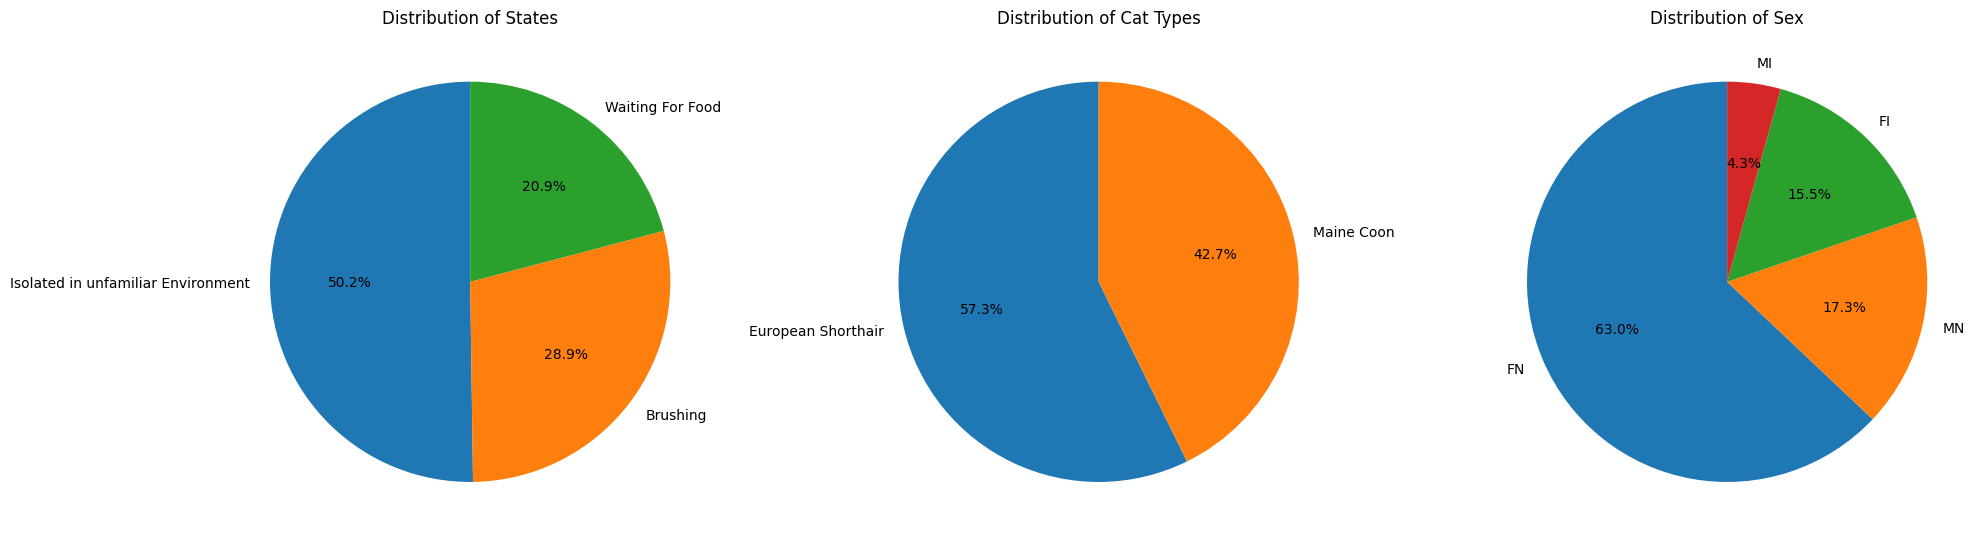

In [12]:
# Vẽ các biểu đồ tròn
fig, axs = plt.subplots(1, 3, figsize=(20, 10))
state_counts = df['State'].value_counts()
axs[0].pie(state_counts, labels=state_counts.index, autopct='%1.1f%%', startangle=90)
axs[0].set_title('Distribution of States')
cat_type_counts = df['Cat_Type'].value_counts()
axs[1].pie(cat_type_counts, labels=cat_type_counts.index, autopct='%1.1f%%', startangle=90)
axs[1].set_title('Distribution of Cat Types')
sex_counts = df['Sex'].value_counts()
axs[2].pie(sex_counts, labels=sex_counts.index, autopct='%1.1f%%', startangle=90)
axs[2].set_title('Distribution of Sex')

plt.tight_layout()
plt.show()

- Kiểm tra ngẫu nhiên file audio

In [13]:
random_rows = df.sample(n=12)
filepath = DATA_PATH + random_rows.iloc[0].Audio_Path
data , sample_rate = librosa.load(filepath)
librosa.load(filepath)
sample_rate

22050

In [14]:
ipd.Audio(filepath)

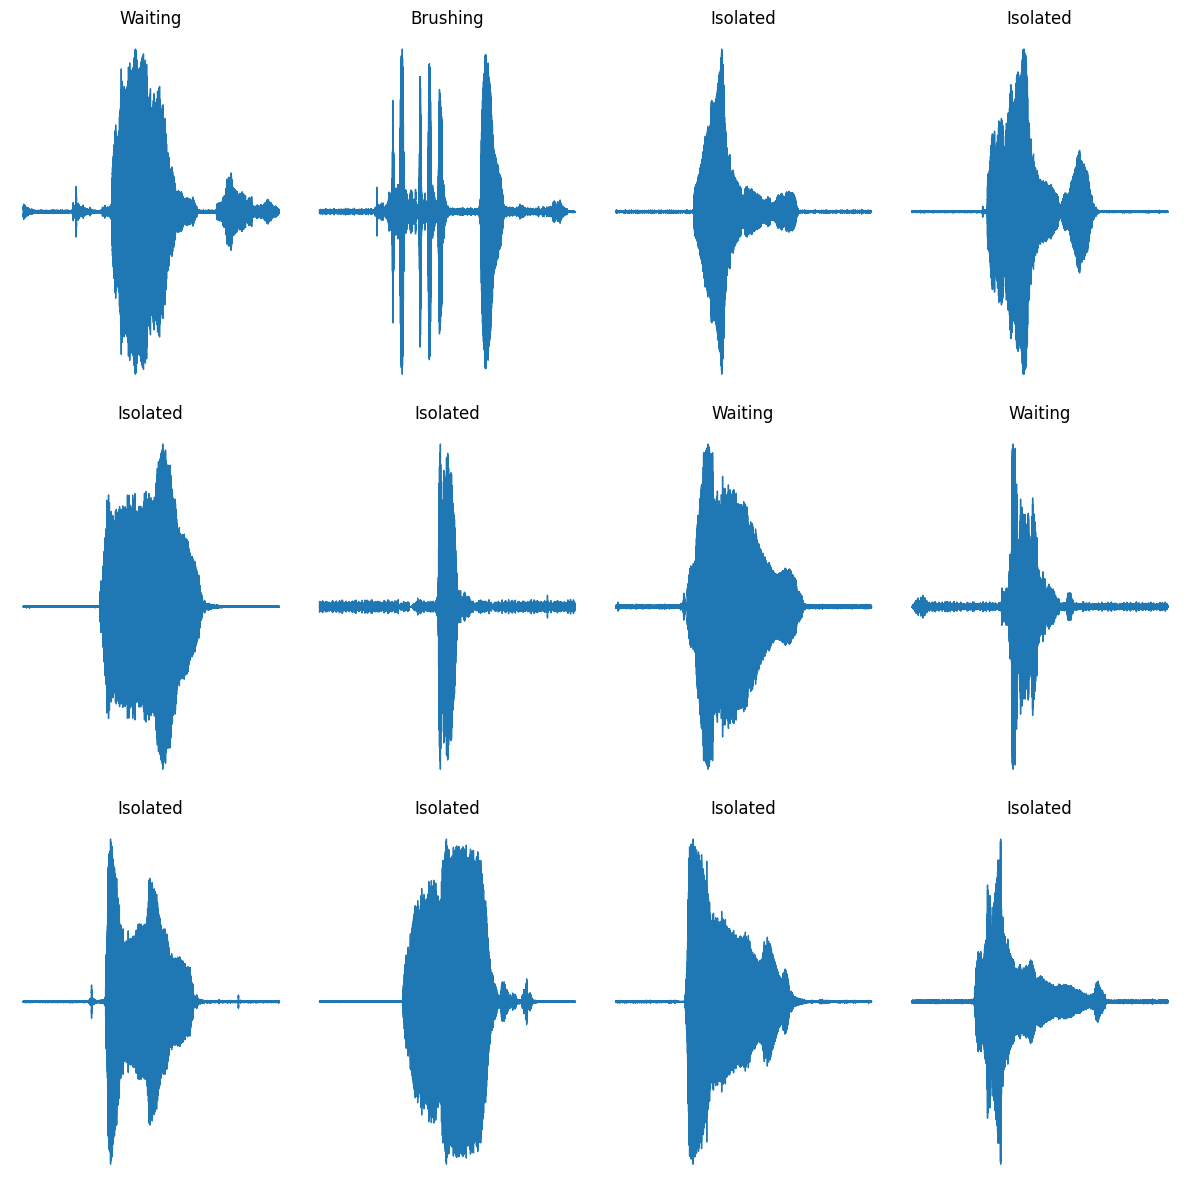

In [15]:
plt.figure(figsize=(12,12))
for i in range(12):
    random_row = random_rows.iloc[i]
    axs = plt.subplot(3,4,i+1)
    filepath = DATA_PATH + random_row.Audio_Path
    data , sample_rate = librosa.load(filepath)
    librosa.load(filepath)
    librosa.display.waveshow(data,ax=axs)
    plt.title(random_row.State.split(" ")[0])
    plt.axis("off")

plt.tight_layout()
plt.show()

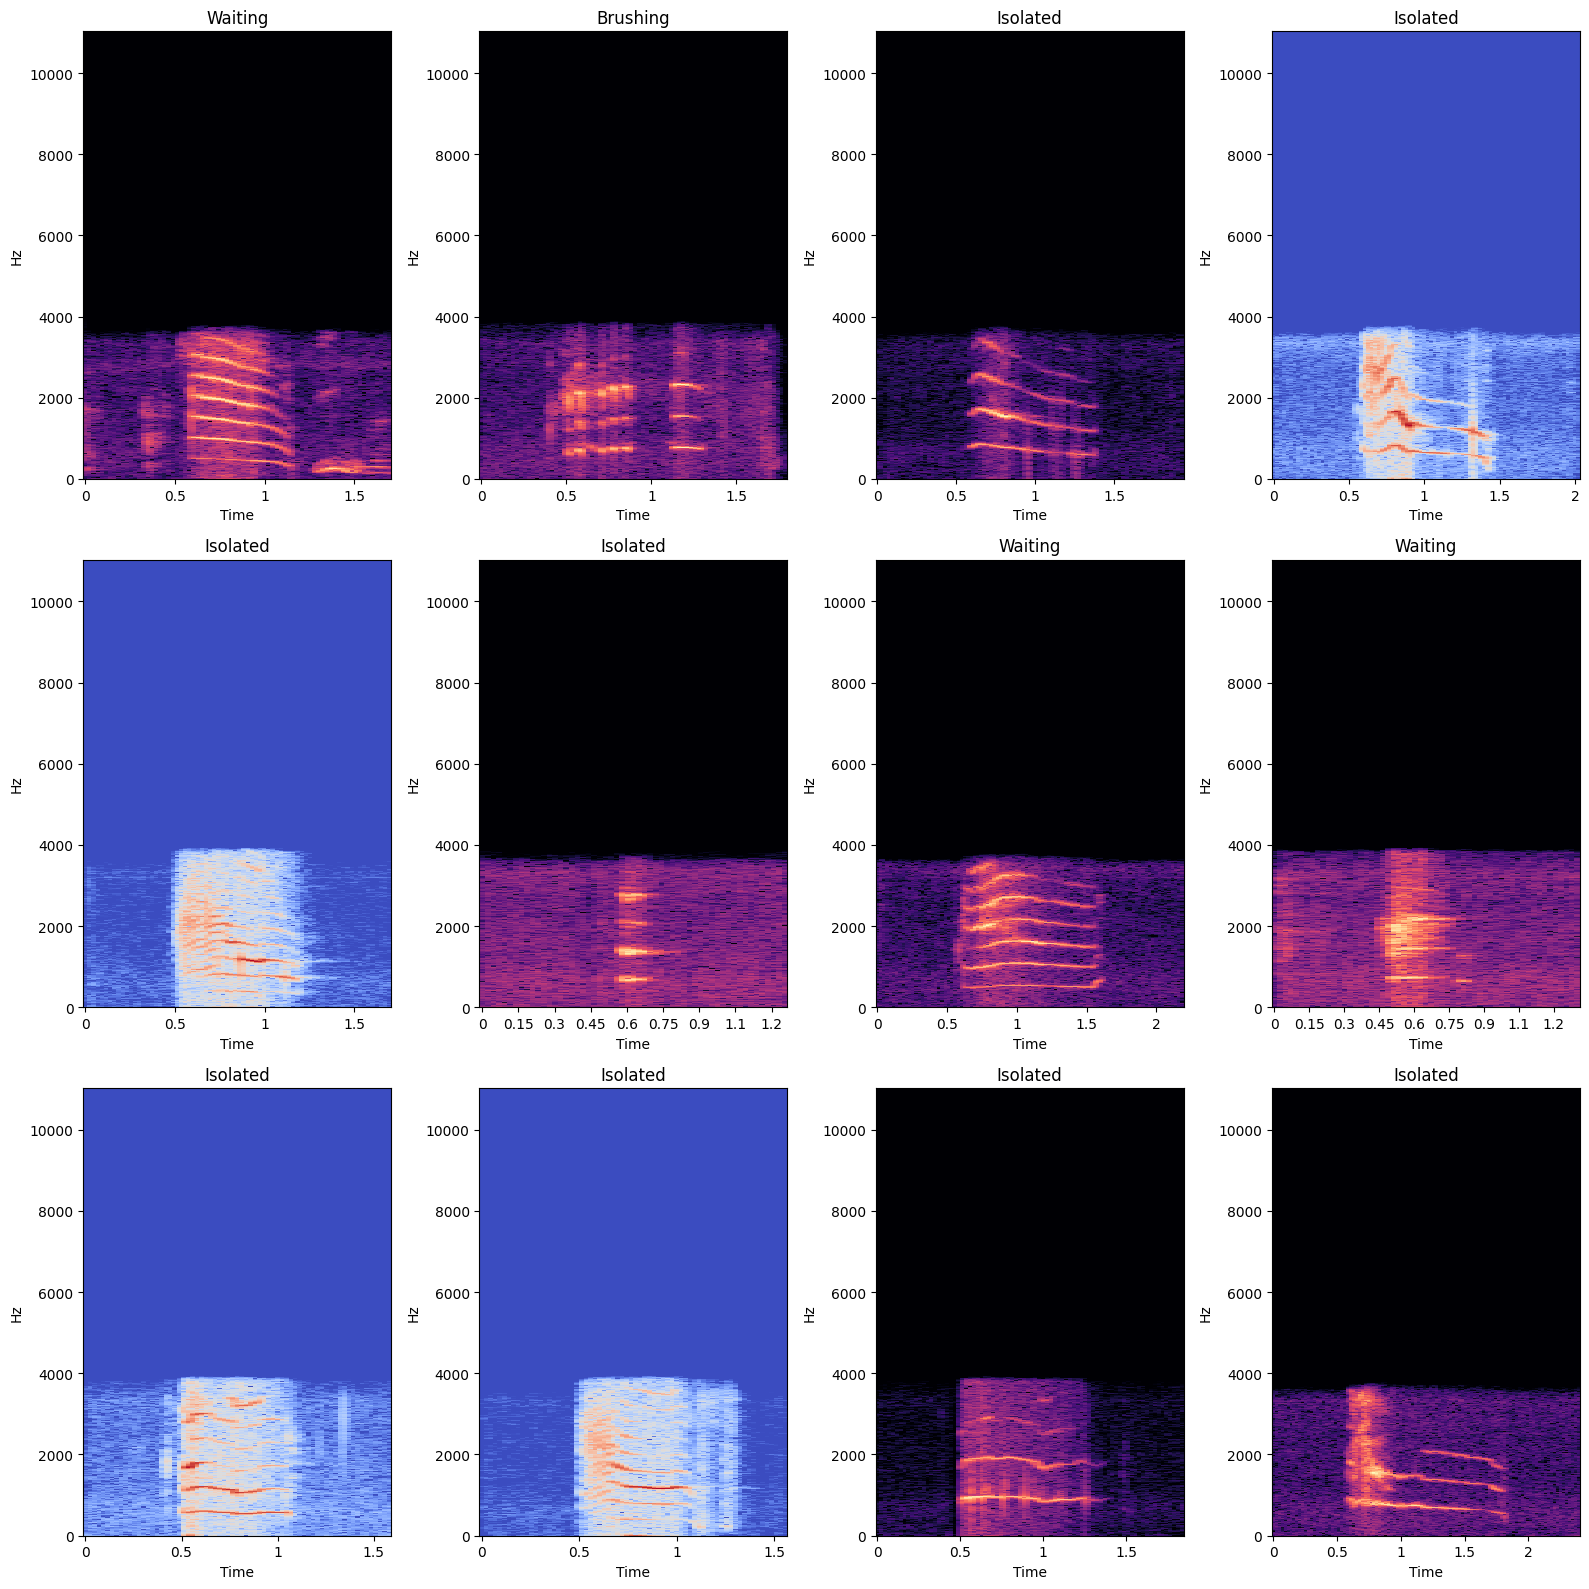

In [16]:
plt.figure(figsize=(16,16))
for i in range(12):
    random_row = random_rows.iloc[i]
    axs = plt.subplot(3,4,i+1)
    filepath = DATA_PATH + random_row.Audio_Path
    data , sample_rate = librosa.load(filepath)
    librosa.load(filepath)
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    librosa.display.specshow(Xdb, sr=sample_rate, x_axis='time', y_axis='hz',ax=axs)
    plt.title(random_row.State.split(" ")[0])

plt.tight_layout()
plt.show()

## 3. Tạo tập dữ liệu train và test

### 3.1. Một số hàm cần thiết

- Load file wav và nén theo sample rate đầu vào

In [17]:
def wav_to_array(path,sample_rate):
    array_wav, sr = librosa.load(path,sr=sample_rate)
    return array_wav

- Tăng cường dữ liệu (data augmentation)

In [18]:
# Thêm nhiễu Gaussian vào tín hiệu âm thanh gốc.
def noise(data):
    noise_amp = 0.025 * np.random.uniform() * np.amax(data)
    data = data + noise_amp * np.random.normal(size=data.shape[0])
    return data

In [19]:
# Thay đổi tốc độ phát âm thanh mà không thay đổi cao độ.
def stretch(data):
    return librosa.effects.time_stretch(data, rate=0.9)

In [20]:
# Thay đổi cao độ của tín hiệu âm thanh mà không thay đổi tốc độ.
def pitch(data, sr):
    return librosa.effects.pitch_shift(data, sr=sr, n_steps=3)

- Trích xuất đặc trưng ảnh

In [21]:
# Zero Crossing Rate (ZCR): Tần suất mà tín hiệu âm thanh đi qua trục hoành (giá trị zero)
def ZCR(data):
    return np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)

In [22]:
# STFT (Short-Time Fourier Transform): Biến đổi Fourier ngắn hạn để phân tích tần số.
def STFT(data):
    stft = np.abs(librosa.stft(data))
    return np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)

In [23]:
# MFCC (Mel-frequency cepstral coefficients): Hệ số cepstral trong thang đo Mel, thường dùng trong nhận dạng giọng nói.
def MFCC(data):
    return np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)

In [24]:
# Root Mean Square Value (RMS): Giá trị trung bình bình phương gốc của tín hiệu âm thanh, biểu thị năng lượng.
def RMS(data):
    return np.mean(librosa.feature.rms(y=data).T, axis=0)

In [25]:
# Mel Spectrogram: Biểu đồ biểu diễn năng lượng tín hiệu âm thanh trong thang Mel.
def MS(data):
    return np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)

In [36]:
def Extract_Allfeatures(data):
    features = [ZCR(data),STFT(data),MFCC(data),RMS(data),MS(data)]
    result = features[0]
    for i in range(1,len(features)):
        result = np.hstack((result,features[i]))
    return result

### 3.2. Tiền xử lý và biến đổi dữ liệu thành đặc trưng

In [37]:
wav_dict.keys()

dict_keys(['F', 'I', 'B'])

In [44]:
key_map = {
    'F':np.array([1,0,0]),
    'I':np.array([0,1,0]),
    'B':np.array([0,0,1])
}

In [58]:
def Preprocressing_data(data_augmentation=False,sample_rate=16000):
    X = []
    y = []
    for key in wav_dict:
        for path in wav_dict[key]:
            array_wav = wav_to_array(DATA_PATH + path,sample_rate)
            features = Extract_Allfeatures(array_wav)
            if data_augmentation:
                noise_array_wav = noise(array_wav)
                features = np.vstack((features, Extract_Allfeatures(noise_array_wav)))
                stretch_array_wav = stretch(array_wav)
                features = np.vstack((features, Extract_Allfeatures(stretch_array_wav)))
                pitch_array_wav = pitch(array_wav,sample_rate)
                features = np.vstack((features, Extract_Allfeatures(pitch_array_wav)))
            X.append(features)
            y.append(key_map[key])
    return X,y

### 3.3. Chia tập dữ liệu

In [65]:
X,y = Preprocressing_data(data_augmentation=True,sample_rate=16000)
X_train, X_test,y_train, y_test = train_test_split(np.array(X),np.array(y),random_state=42,test_size=0.15,shuffle=True)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((374, 4, 162), (374, 3), (66, 4, 162), (66, 3))

In [76]:
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((374, 4, 1, 162), (374, 3), (66, 4, 1, 162), (66, 3))

## 4. Xây dựng mô hình

### 4.1. Setup các thông số mô hình

- Thông số mô hình

In [77]:
EPOCH = 100
INPUT_SHAPE = X_train.shape
NUM_CLASSES = 3

### 4.2. Xây dựng kiến trúc mô hình

In [79]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), kernel_initializer='he_uniform', padding='same', input_shape=(374, 4, 162)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2), padding='same'),

    # Lớp Conv2D thứ hai với Batch Normalization và ReLU activation
    layers.Conv2D(64, (3, 3), kernel_initializer='he_uniform', padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2), padding='same'),

    # Lớp Conv2D thứ ba với Batch Normalization và ReLU activation
    layers.Conv2D(128, (3, 3), kernel_initializer='he_uniform', padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2), padding='same'),

    # Lớp Conv2D thứ tư với Batch Normalization và ReLU activation
    layers.Conv2D(256, (3, 3), kernel_initializer='he_uniform', padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2), padding='same'),

    # Flatten để chuẩn bị cho lớp Dense
    layers.Flatten(),

    # Lớp Dense với Batch Normalization và ReLU activation
    layers.Dense(64, kernel_initializer='he_uniform'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dense(NUM_CLASSES, activation='softmax'),
])

model.build(input_shape=(None, *INPUT_SHAPE))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 374, 4, 32)        46688     
                                                                 
 batch_normalization_20 (Bat  (None, 374, 4, 32)       128       
 chNormalization)                                                
                                                                 
 activation_20 (Activation)  (None, 374, 4, 32)        0         
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 187, 2, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 187, 2, 64)        18496     
                                                                 
 batch_normalization_21 (Bat  (None, 187, 2, 64)      

In [80]:
history = model.fit(X_train, y_train,
                    epochs=EPOCH,
                    batch_size=128,
                    validation_data=(X_test, y_test))

Epoch 1/100


ValueError: in user code:

    File "C:\Users\ADMIN\anaconda3\envs\py310\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\ADMIN\anaconda3\envs\py310\lib\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\ADMIN\anaconda3\envs\py310\lib\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\ADMIN\anaconda3\envs\py310\lib\site-packages\keras\engine\training.py", line 993, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\ADMIN\anaconda3\envs\py310\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\ADMIN\anaconda3\envs\py310\lib\site-packages\keras\engine\input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_4" is incompatible with the layer: expected shape=(None, 374, 4, 162), found shape=(None, 4, 1, 162)
